<a href="https://colab.research.google.com/github/anpham1331372/ECGR5106/blob/main/ECGR5106_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20: Loss=1.6549, Train Acc=0.4123, Val Acc=0.4770
Epoch 2/20: Loss=1.4470, Train Acc=0.4893, Val Acc=0.4781
Epoch 3/20: Loss=1.3463, Train Acc=0.5221, Val Acc=0.5128
Epoch 4/20: Loss=1.2625, Train Acc=0.5512, Val Acc=0.5152
Epoch 5/20: Loss=1.1979, Train Acc=0.5755, Val Acc=0.5237
Epoch 6/20: Loss=1.1385, Train Acc=0.5926, Val Acc=0.5221
Epoch 7/20: Loss=1.0820, Train Acc=0.6126, Val Acc=0.5335
Epoch 8/20: Loss=1.0292, Train Acc=0.6318, Val Acc=0.5343
Epoch 9/20: Loss=0.9806, Train Acc=0.6469, Val Acc=0.5290
Epoch 10/20: Loss=0.9355, Train Acc=0.6636, Val Acc=0.5342
Epoch 11/20: Loss=0.8961, Train Acc=0.6772, Val Acc=0.5280
Epoch 12/20: Loss=0.8478, Train Acc=0.6940, Val Acc=0.5345
Epoch 13/20: Loss=0.8153, Train Acc=0.7051, Val Acc=0.5343
Epoch 14/20: Loss=0.7850, Train Acc=0.7169, Val Acc=0.5357
Epoch 15/20: Loss=0.7559, Train Acc=0.7259, Val Acc=0.5290
Epoch 16/20: Loss=0.7187, Trai

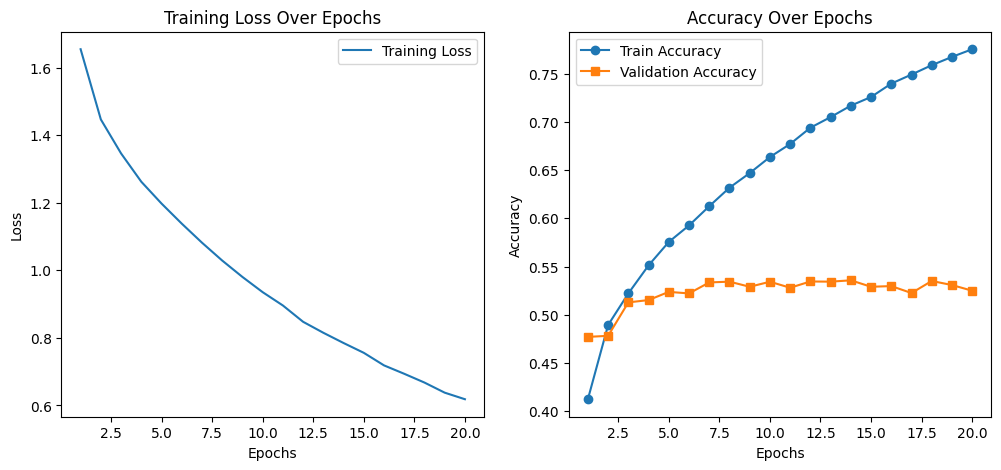

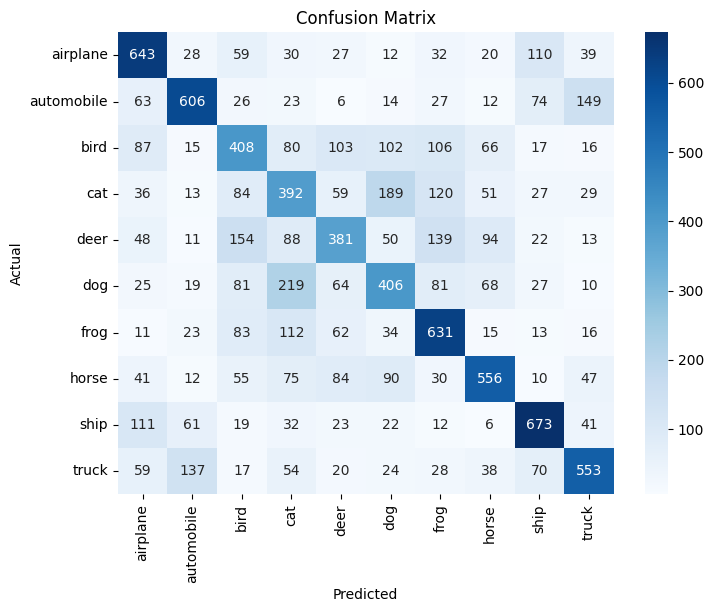

Precision: 0.5260, Recall: 0.5249, F1 Score: 0.5239


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CIFAR-10 Dataset & Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load CIFAR-10 dataset
batch_size = 32
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define MLP Model
class MLP_CIFAR10(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_dims=[256, 128, 64], output_size=10):
        super(MLP_CIFAR10, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation (CrossEntropyLoss includes softmax)
        return x

# Initialize model
model = MLP_CIFAR10().to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, epoch_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Store training metrics
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation Accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracies.append(correct / total)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")

# Evaluate on test set
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Ensure directory exists before saving
os.makedirs("./models", exist_ok=True)
torch.save(model.state_dict(), "./models/mlp_cifar10.pth")

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print Evaluation Metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Using device: cpu


100%|██████████| 170M/170M [00:03<00:00, 51.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/20: Loss=1.7495, Train Acc=0.3727, Val Acc=0.4386
Epoch 2/20: Loss=1.5044, Train Acc=0.4693, Val Acc=0.4822
Epoch 3/20: Loss=1.3848, Train Acc=0.5100, Val Acc=0.5058
Epoch 4/20: Loss=1.2901, Train Acc=0.5453, Val Acc=0.5135
Epoch 5/20: Loss=1.2129, Train Acc=0.5700, Val Acc=0.5169
Epoch 6/20: Loss=1.1429, Train Acc=0.5957, Val Acc=0.5212
Epoch 7/20: Loss=1.0728, Train Acc=0.6193, Val Acc=0.5188
Epoch 8/20: Loss=1.0152, Train Acc=0.6432, Val Acc=0.5384
Epoch 9/20: Loss=0.9571, Train Acc=0.6612, Val Acc=0.5345
Epoch 10/20: Loss=0.8980, Train Acc=0.6824, Val Acc=0.5326
Epoch 11/20: Loss=0.8432, Train Acc=0.7017, Val Acc=0.5429
Epoch 12/20: Loss=0.8020, Train Acc=0.7128, Val Acc=0.5411
Epoch 13/20: Loss=0.7564, Train Acc=0.7350, Val Acc=0.5402
Epoch 14/20: Loss=0.7100, Train Acc=0.7503, Val Acc=0.5370
Epoch 15/20: Loss=0.6781, Train Acc=0.7610, Val Acc=0.5410
Epoch 16/20: Loss=0.6419, Train Acc

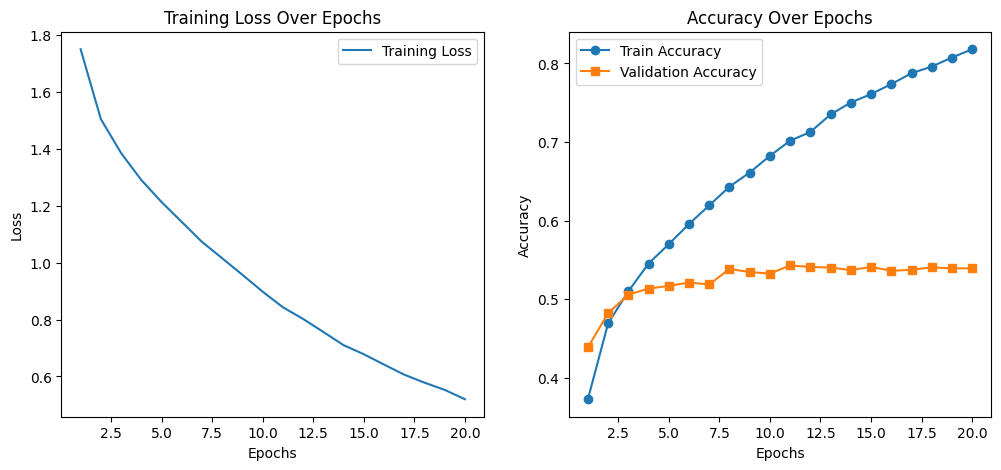

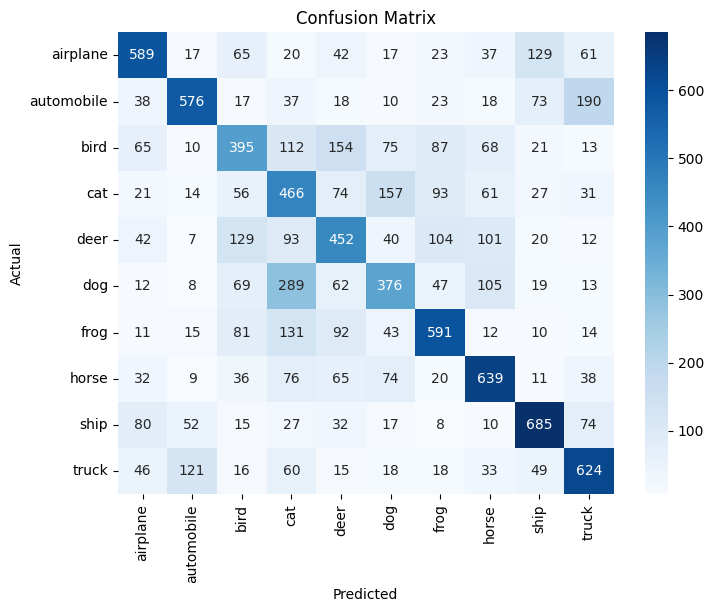

Precision: 0.5445, Recall: 0.5393, F1 Score: 0.5398


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CIFAR-10 Dataset & Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load CIFAR-10 dataset
batch_size = 32
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define a more complex MLP for CIFAR-10 with increased depth and width
class MLP_CIFAR10_Complex(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_dims=[512, 256, 128, 64, 32], output_size=10):
        super(MLP_CIFAR10_Complex, self).__init__()
        self.flatten = nn.Flatten()

        # Dynamically build the network layers
        layers = []
        prev_dim = input_size
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim

        # Final output layer (no activation, as CrossEntropyLoss applies softmax)
        layers.append(nn.Linear(prev_dim, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        x = self.network(x)
        return x

# Initialize the complex model
model = MLP_CIFAR10_Complex().to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, epoch_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Store training metrics
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation Accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracies.append(correct / total)
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")

# Evaluate on test set
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute evaluation metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Save the model
#os.makedirs("./models", exist_ok=True)
#torch.save(model.state_dict(), "./models/mlp_cifar10_complex.pth")

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print Evaluation Metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-21-dc91f014c204>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(categorical_mapping, inplace=True)


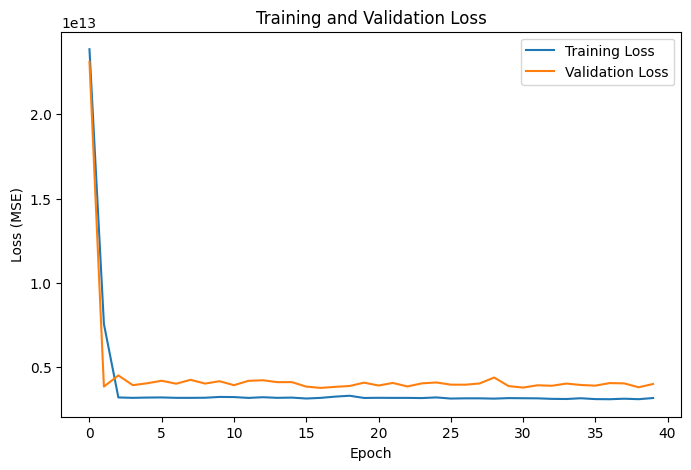

Final Training Loss: 3179186271448.0732
Final Validation Loss: 4010324044057.8350
Final Training Accuracy: -0.0287
Final Validation Accuracy: 0.2139
Total Trainable Parameters: 3009
Final Training Loss: 3179186271448.0732
Final Validation Loss: 4010324044057.8350
Final Training Loss: 3179186271448.0732
Final Validation Loss: 4010324044057.8350
Total Trainable Parameters: 3009
Total Trainable Parameters: 3009


In [21]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
# Assuming the dataset is named 'Housing.csv'
data_path = '/content/drive/MyDrive/ECGR 5106 - Real-Time ML/Housing.csv'
df = pd.read_csv(data_path)

# Features and target based on the image
features = [
    'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
    'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
    'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished'
]
target = 'price'

# Encode categorical features ('yes' -> 1, 'no' -> 0) and use one-hot encoding for 'furnishingstatus'
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)
categorical_mapping = {
    'yes': 1,
    'no': 0,
    'furnished': 2,
    'semi-furnished': 1,
    'unfurnished': 0
}
df.replace(categorical_mapping, inplace=True)

# Ensure all columns are numeric and handle missing values
df = df.fillna(0)  # Fill missing values with 0 to avoid type issues

# Extract features and target
X = df[features].astype(float).values
y = df[target].values

# Split the dataset into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create DataLoaders for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the MLP regression model
class HousingRegressionNet(nn.Module):
    def __init__(self, input_dim):
        super(HousingRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = HousingRegressionNet(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 40
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Report final accuracy and model complexity
final_train_loss = train_loss_list[-1]
final_val_loss = val_loss_list[-1]
train_accuracy = 1 - final_train_loss / y_train.var().item()
val_accuracy = 1 - final_val_loss / y_val.var().item()
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Training Accuracy: {train_accuracy:.4f}')
print(f'Final Validation Accuracy: {val_accuracy:.4f}')
print(f'Total Trainable Parameters: {total_params}')
final_train_loss = train_loss_list[-1]
final_val_loss = val_loss_list[-1]
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')

# Compare results to the model without one-hot encoding and analyze meaningful changes
if 'total_params_no_one_hot' in globals():
    print(f"Parameters without one-hot encoding: {total_params_no_one_hot}")
    print(f"Parameters with one-hot encoding: {total_params}")
    print("Do you see meaningful changes against the previous model?")
final_train_loss = train_loss_list[-1]
final_val_loss = val_loss_list[-1]
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Total Trainable Parameters: {total_params}')

# Calculate model complexity (total number of trainable parameters)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {total_params}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-29-0f9845bd001b>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'yes': 1, 'no': 0}, inplace=True)


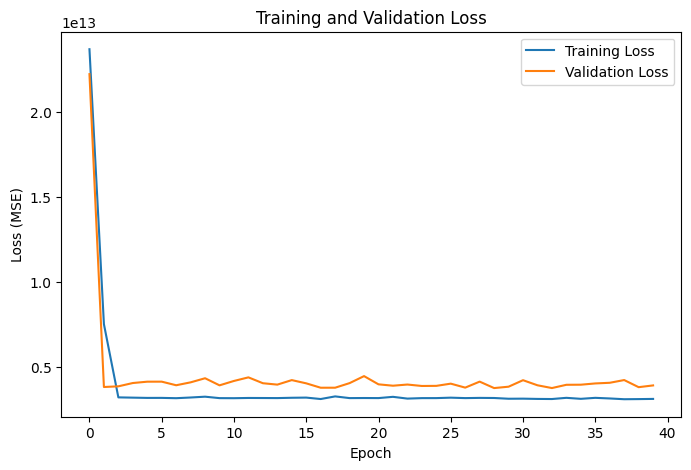

Final Training Loss: 3138995305744.4404
Final Validation Loss: 3930648314156.6240
Final Training Accuracy: -0.0157
Final Validation Accuracy: 0.2295
Total Trainable Parameters: 3009


In [29]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
# Assuming the dataset is named 'Housing.csv'
data_path = '/content/drive/MyDrive/ECGR 5106 - Real-Time ML/Housing.csv'
df = pd.read_csv(data_path)

# Features and target based on the image
features = [
    'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
    'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
    'furnishingstatus_furnished', 'furnishingstatus_semi-furnished'
]
target = 'price'

# Encode categorical features ('yes' -> 1, 'no' -> 0) and use one-hot encoding for 'furnishingstatus'
df = pd.get_dummies(df, columns=['furnishingstatus'])

# Ensure all categorical variables are encoded
df.replace({'yes': 1, 'no': 0}, inplace=True)

# Ensure all columns are numeric and handle missing values
df = df.fillna(0)  # Fill missing values with 0 to avoid type issues

# Extract features and target
X = df[features].astype(float).values
y = df[target].values

# Split the dataset into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create DataLoaders for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the MLP regression model
class HousingRegressionNet(nn.Module):
    def __init__(self, input_dim):
        super(HousingRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = HousingRegressionNet(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 40
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Report final accuracy and model complexity
final_train_loss = train_loss_list[-1]
final_val_loss = val_loss_list[-1]
train_accuracy = 1 - final_train_loss / y_train.var().item()
val_accuracy = 1 - final_val_loss / y_val.var().item()
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Training Accuracy: {train_accuracy:.4f}')
print(f'Final Validation Accuracy: {val_accuracy:.4f}')

# Calculate model complexity (total number of trainable parameters)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {total_params}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-30-0f9845bd001b>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'yes': 1, 'no': 0}, inplace=True)


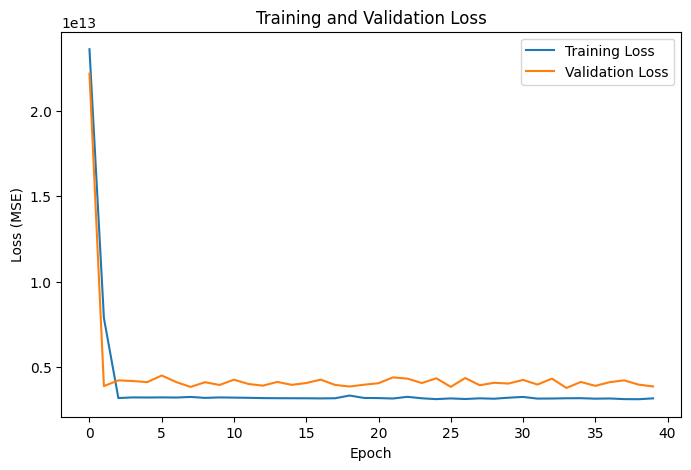

Final Training Loss: 3163276065463.1929
Final Validation Loss: 3860621801866.5688
Final Training Accuracy: -0.0236
Final Validation Accuracy: 0.2432
Total Trainable Parameters: 3009


In [30]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
# Assuming the dataset is named 'Housing.csv'
data_path = '/content/drive/MyDrive/ECGR 5106 - Real-Time ML/Housing.csv'
df = pd.read_csv(data_path)

# Features and target based on the image
features = [
    'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
    'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
    'furnishingstatus_furnished', 'furnishingstatus_semi-furnished'
]
target = 'price'

# Encode categorical features ('yes' -> 1, 'no' -> 0) and use one-hot encoding for 'furnishingstatus'
df = pd.get_dummies(df, columns=['furnishingstatus'])

# Ensure all categorical variables are encoded
df.replace({'yes': 1, 'no': 0}, inplace=True)

# Ensure all columns are numeric and handle missing values
df = df.fillna(0)  # Fill missing values with 0 to avoid type issues

# Extract features and target
X = df[features].astype(float).values
y = df[target].values

# Split the dataset into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create DataLoaders for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the MLP regression model
class HousingRegressionNet(nn.Module):
    def __init__(self, input_dim):
        super(HousingRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = HousingRegressionNet(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 40
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Report final accuracy and model complexity
final_train_loss = train_loss_list[-1]
final_val_loss = val_loss_list[-1]
train_accuracy = 1 - final_train_loss / y_train.var().item()
val_accuracy = 1 - final_val_loss / y_val.var().item()
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Training Accuracy: {train_accuracy:.4f}')
print(f'Final Validation Accuracy: {val_accuracy:.4f}')

# Calculate model complexity (total number of trainable parameters)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {total_params}')
